In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 384 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
258076736/258076736 [==============================] - 2s 0us/step
Epoch 1/10
12/12 [==============================] - 366s 26s/step - loss: 0.7160 - accuracy: 0.4948 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 2/10
12/12 [==============================] - 328s 27s/step - loss: 0.7182 - accuracy: 0.4792 - val_loss: 0.6773 - val_accuracy: 0.6042
Epoch 3/10
12/12 [==============================] - 308s 26s/step - loss: 0.6872 - accuracy: 0.5391 - val_loss: 0.6654 - val_accuracy: 0.6979
Epoch 4/10
12/12 [==============================] - 319s 27s/step - loss: 0.6814 - accuracy: 0.5495 - val_loss: 0.6563 - val_accuracy: 0.6458
Epoch 5/10
12/12 [==============================] - 327s 28s/step - loss: 0.6730 - accuracy: 0.5703 - val_loss: 0.6516 - val_accuracy: 0.6250
Epoch 6/10
12/12 [==============================] - 301s 25s/step - loss: 0.6826 - accuracy: 0.5677 - val_loss: 0.6494 - val_accuracy: 0.6146


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

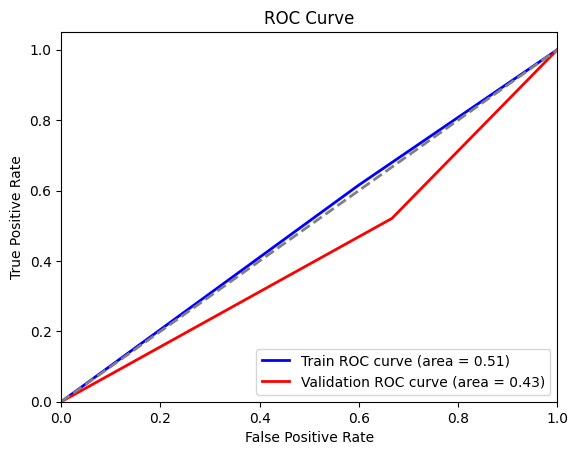

In [ ]:
# Step 1: Set up Google Colab environment and import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# Step 2: Load and preprocess the dataset

# Define paths
base_dir = '/content/drive/MyDrive/Laboratory'
positive_dir = os.path.join(base_dir, 'Positive')
negative_dir = os.path.join(base_dir, 'Negative')

# Create ImageDataGenerator objects
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Step 3: Build the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Step 5: Evaluate the model
train_generator.reset()
validation_generator.reset()

# Predictions
train_predictions = model.predict(train_generator)
val_predictions = model.predict(validation_generator)

# Convert predictions to binary
train_predictions = np.where(train_predictions > 0.5, 1, 0)
val_predictions = np.where(val_predictions > 0.5, 1, 0)

# Get true labels
train_labels = train_generator.classes
val_labels = validation_generator.classes

# Performance metrics
train_accuracy = accuracy_score(train_labels, train_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)
train_precision = precision_score(train_labels, train_predictions)
val_precision = precision_score(val_labels, val_predictions)
train_recall = recall_score(train_labels, train_predictions)
val_recall = recall_score(val_labels, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Validation Precision: {val_precision}')
print(f'Train Recall: {train_recall}')
print(f'Validation Recall: {val_recall}')

# Classification report
print('Train Classification Report:')
print(classification_report(train_labels, train_predictions))
print('Validation Classification Report:')
print(classification_report(val_labels, val_predictions))

# Step 6: Save predictions to CSV
train_filenames = train_generator.filenames
val_filenames = validation_generator.filenames

train_results = pd.DataFrame({
    'Filename': train_filenames,
    'TrueLabel': train_labels,
    'Prediction': train_predictions.flatten()
})

val_results = pd.DataFrame({
    'Filename': val_filenames,
    'TrueLabel': val_labels,
    'Prediction': val_predictions.flatten()
})

train_results.to_csv('train_predictions.csv', index=False)
val_results.to_csv('val_predictions.csv', index=False)

# Download CSV files
from google.colab import files
files.download('train_predictions.csv')
files.download('val_predictions.csv')

# Step 7: Plot ROC curve
train_fpr, train_tpr, _ = roc_curve(train_labels, train_predictions)
val_fpr, val_tpr, _ = roc_curve(val_labels, val_predictions)
train_roc_auc = auc(train_fpr, train_tpr)
val_roc_auc = auc(val_fpr, val_tpr)

plt.figure()
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC curve (area = {train_roc_auc:.2f})')
plt.plot(val_fpr, val_tpr, color='red', lw=2, label=f'Validation ROC curve (area = {val_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()